# QUBIC 1D
# TOD Realism
## JCH - Feb 2025
In this notebook we investigate the issue of TOD realism mentioned in `QUBIC-1D.ipynb`.

## Mandatory Imports

In [1]:
%matplotlib ipympl


import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.signal
from importlib import reload    

from qubic.lib import Q1d as q1d 

sz = 10.
plt.rc('figure',figsize=(sz,sz/1.618))
plt.rc('font',size=10)
plt.rc('image', cmap='jet')

In [34]:
reload(q1d)

params = q1d.params.copy()


params['plot_sky']           = False
params['plot_sb']            = False
params['plot_expected']      = False
params['plot_pointings']     = False
params['plot_TOD']           = False
params['plot_reconstructed'] = False

params['sky_seed']           = 1                    # Seed for the sky simulation
params['pointing_seed']      = 1                    # Seed for the pointing
params['noise_seed']         = None                 # Seed for the noise

params['noise_rms']          = 0.                   # RMS noise per time sample

# We run the whole process once to have a sky, piellization, pointing etc...
res = q1d.run_1d_simulation(params)


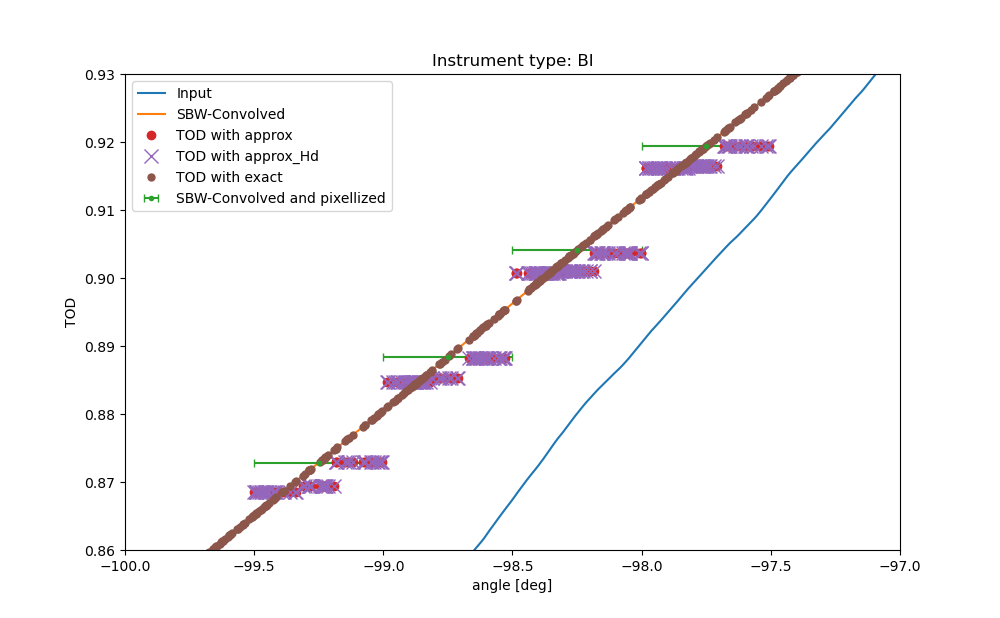

In [43]:
params['instrument_type'] = 'BI'

TOD_approx, convolved_approx, convolved_pix_approx, _ = q1d.build_TOD(params, 
                              (res['xpix'], res['truey']), res['ptg_deg'], res['pix_center'], algo='approx')

TOD_approx_Hd, convolved_approx_Hd, convolved_pix_approx_Hd, _ = q1d.build_TOD(params, 
                              (res['xpix'], res['truey']), res['ptg_deg'], res['pix_center'], algo='approx_Hd')

TOD_exact, convolved_exact, convolved_pix_exact, _ = q1d.build_TOD(params, 
                              (res['xpix'], res['truey']), res['ptg_deg'], res['pix_center'], algo='exact')

dx = res['pix_center'][1]-res['pix_center'][0]

plt.figure()
plt.plot(res['xpix'], res['truey'], label='Input')
plt.plot(res['xpix'], convolved_exact, label='SBW-Convolved')
plt.errorbar(res['pix_center'], convolved_pix_exact, xerr=dx/2, fmt='.', capsize=3, label='SBW-Convolved and pixellized')
plt.plot(res_bi_approx['ptg_deg'], res_bi_approx['TOD'][0,:], 'o', label='TOD with approx')
plt.plot(res_bi_approx_Hd['ptg_deg'], res_bi_approx_Hd['TOD'][0,:], 'x', ms=10, label='TOD with approx_Hd')
plt.plot(res_bi_exact['ptg_deg'], res_bi_exact['TOD'][0,:], '.', ms=10, label='TOD with exact')
plt.xlabel('angle [deg]')
plt.ylabel('TOD')
plt.title('Instrument type: '+params['instrument_type'])
plt.xlim(-100, -97)
plt.ylim(0.86, 0.93)
plt.legend()


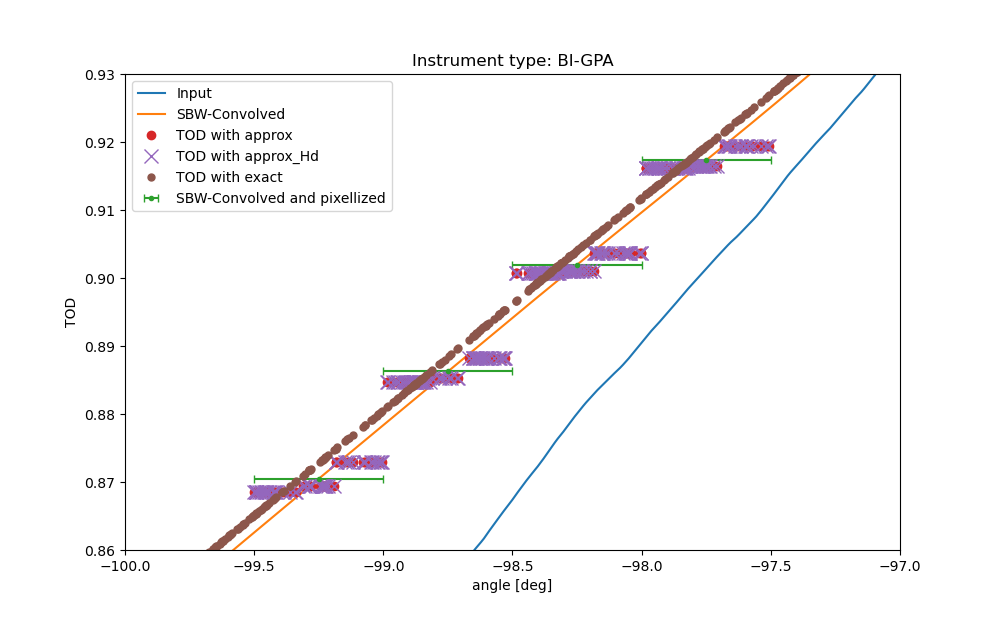

In [44]:
params['instrument_type'] = 'BI-GPA'

TOD_approx, convolved_approx, convolved_pix_approx, _ = q1d.build_TOD(params, 
                              (res['xpix'], res['truey']), res['ptg_deg'], res['pix_center'], algo='approx')

TOD_approx_Hd, convolved_approx_Hd, convolved_pix_approx_Hd, _ = q1d.build_TOD(params, 
                              (res['xpix'], res['truey']), res['ptg_deg'], res['pix_center'], algo='approx_Hd')

TOD_exact, convolved_exact, convolved_pix_exact, _ = q1d.build_TOD(params, 
                              (res['xpix'], res['truey']), res['ptg_deg'], res['pix_center'], algo='exact')

dx = res['pix_center'][1]-res['pix_center'][0]

plt.figure()
plt.plot(res['xpix'], res['truey'], label='Input')
plt.plot(res['xpix'], convolved_exact, label='SBW-Convolved')
plt.errorbar(res['pix_center'], convolved_pix_exact, xerr=dx/2, fmt='.', capsize=3, label='SBW-Convolved and pixellized')
plt.plot(res_bi_approx['ptg_deg'], res_bi_approx['TOD'][0,:], 'o', label='TOD with approx')
plt.plot(res_bi_approx_Hd['ptg_deg'], res_bi_approx_Hd['TOD'][0,:], 'x', ms=10, label='TOD with approx_Hd')
plt.plot(res_bi_exact['ptg_deg'], res_bi_exact['TOD'][0,:], '.', ms=10, label='TOD with exact')
plt.xlabel('angle [deg]')
plt.ylabel('TOD')
plt.title('Instrument type: '+params['instrument_type'])
plt.xlim(-100, -97)
plt.ylim(0.86, 0.93)
plt.legend()


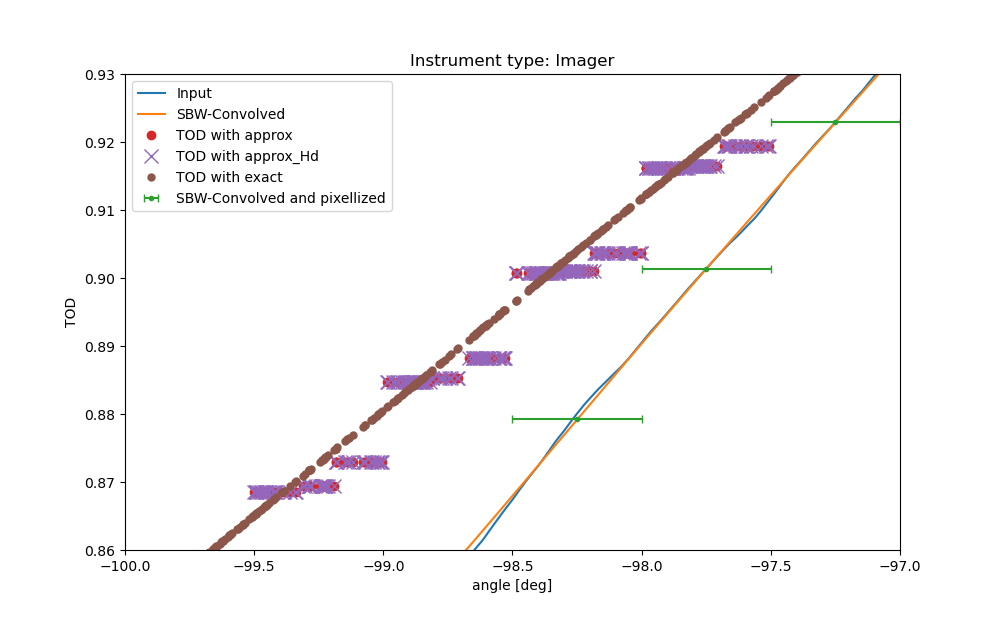

In [45]:
params['instrument_type'] = 'Imager'

TOD_approx, convolved_approx, convolved_pix_approx, _ = q1d.build_TOD(params, 
                              (res['xpix'], res['truey']), res['ptg_deg'], res['pix_center'], algo='approx')

TOD_approx_Hd, convolved_approx_Hd, convolved_pix_approx_Hd, _ = q1d.build_TOD(params, 
                              (res['xpix'], res['truey']), res['ptg_deg'], res['pix_center'], algo='approx_Hd')

TOD_exact, convolved_exact, convolved_pix_exact, _ = q1d.build_TOD(params, 
                              (res['xpix'], res['truey']), res['ptg_deg'], res['pix_center'], algo='exact')

dx = res['pix_center'][1]-res['pix_center'][0]

plt.figure()
plt.plot(res['xpix'], res['truey'], label='Input')
plt.plot(res['xpix'], convolved_exact, label='SBW-Convolved')
plt.errorbar(res['pix_center'], convolved_pix_exact, xerr=dx/2, fmt='.', capsize=3, label='SBW-Convolved and pixellized')
plt.plot(res_bi_approx['ptg_deg'], res_bi_approx['TOD'][0,:], 'o', label='TOD with approx')
plt.plot(res_bi_approx_Hd['ptg_deg'], res_bi_approx_Hd['TOD'][0,:], 'x', ms=10, label='TOD with approx_Hd')
plt.plot(res_bi_exact['ptg_deg'], res_bi_exact['TOD'][0,:], '.', ms=10, label='TOD with exact')
plt.xlabel('angle [deg]')
plt.ylabel('TOD')
plt.title('Instrument type: '+params['instrument_type'])
plt.xlim(-100, -97)
plt.ylim(0.86, 0.93)
plt.legend()
